In [403]:
import pandas as pd
import cudf
import seaborn as sns
import matplotlib.pyplot as plt

In [404]:
# Load dataset
df = pd.read_csv('titanic.csv')
df_test = pd.read_csv('test_titanic.csv')

In [405]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [406]:
# Sets null values equal to the median of that column
def handle_null_median(df):
    # Need to set inplace=True, so it doesn't create a copy of the dataframe. Tried without and this led to null-values not being removed
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    df['Age'].fillna(df['Age'].median(), inplace=True)

    df['Embarked'].fillna('S', inplace=True)

    return  df

df = handle_null_median(df)

In [407]:
df['Sex'] = df['Sex'].replace(['female', 'male'], [0,1])

In [408]:
df['FamilyMembersCount'] = df['Parch'] + df['SibSp'] + 1

In [409]:
df_XGB = df.copy()
df_RF = df.copy()
df_GNB = df.copy()

In [410]:
def bins(df): # This is kind of feature engineering as well
    df['AgeGroup'] = 0
    df.loc[df['Age'] < 16.336, 'AgeGroup' ] = 0
    df.loc[(df['Age'] >= 16.336) & (df['Age'] < 32.252), 'AgeGroup'] = 1
    df.loc[(df['Age'] >= 32.252) & (df['Age'] < 48.168), 'AgeGroup'] = 2
    df.loc[(df['Age'] >= 48.168) & (df['Age'] < 64.084), 'AgeGroup'] = 3
    df.loc[df['Age'] >= 64.084, 'AgeGroup'] = 4

    # Could also create bins for fare, but not sure Fare is needed.
    return df

df_XGB = bins(df)
df_XGB

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilyMembersCount,AgeGroup
0,0,3,1,22.0,1,0,7.2500,S,2,1
1,1,1,0,38.0,1,0,71.2833,C,2,2
2,1,3,0,26.0,0,0,7.9250,S,1,1
3,1,1,0,35.0,1,0,53.1000,S,2,2
4,0,3,1,35.0,0,0,8.0500,S,1,2
...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,S,1,1
887,1,1,0,19.0,0,0,30.0000,S,1,1
888,0,3,0,28.0,1,2,23.4500,S,4,1
889,1,1,1,26.0,0,0,30.0000,C,1,1


In [411]:
df['Pclass'] =  df['Pclass'].astype('category')
df['Embarked'] =  df['Embarked'].astype('category')
df['AgeGroup'] =  df['AgeGroup'].astype('category')

In [412]:
df_XGB = pd.get_dummies(df)
df_RF = pd.get_dummies(df)
df_GNB = pd.get_dummies(df)

In [413]:
from sklearn.model_selection import train_test_split

# XGBoost

In [414]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

train_X, test_X, train_y, test_y = train_test_split(df_XGB.drop('Survived', axis=1), df_XGB['Survived'], random_state=0)

model = XGBClassifier()
model.fit(train_X, train_y)

pred_y = model.predict(test_X)
preds = [round(value) for value in pred_y]

# evaluate predictions
accuracy = accuracy_score(test_y, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[20:45:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 82.96%


C:\Users\marku\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\marku\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [ ]:
from sklearn.model_selection import GridSearchCV
XGBParam = {"subsample":[0.5, 0.75, 1],
              "colsample_bytree":[0.5, 0.75, 1],
              "max_depth":[2, 6, 12],
              "min_child_weight":[1,5,15],
              "learning_rate":[0.3, 0.1, 0.03],
              "n_estimators":[100]}

XGB_grid = GridSearchCV(XGBClassifier(), XGBParam)
XGB_grid.fit(train_X, train_y)

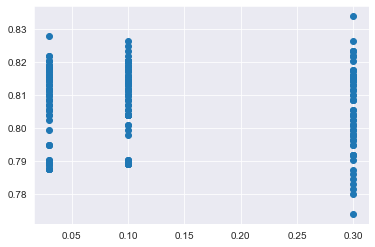

In [419]:
gb_results = pd.DataFrame(XGB_grid.cv_results_)

import matplotlib.pyplot as plt

plt.scatter(gb_results['param_learning_rate'], gb_results['mean_test_score'])

In [420]:
print(XGB_grid.best_score_)

0.8338233643811019


In [421]:
print(XGB_grid.best_params_)

{'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.5}


# Random Forrest Classifier

In [415]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

train_X, test_X, train_y, test_y = train_test_split(df_RF.drop('Survived', axis=1), df_RF['Survived'], random_state=0)

# Train and test random forest classifier with default parameters
rf_scores = cross_val_score(RandomForestClassifier(), train_X, train_y)
(rf_scores.mean(), rf_scores.std())

(0.7919200987543485, 0.021878018230662894)

# GaussianNB

In [416]:
from sklearn.naive_bayes import GaussianNB

train_X, test_X, train_y, test_y = train_test_split(df_RF.drop('Survived', axis=1), df_RF['Survived'], random_state=0)

# Train and test random forest classifier with default parameters
GNB_scores = cross_val_score(GaussianNB(), train_X, train_y)
(GNB_scores.mean(), GNB_scores.std())

(0.6948378408708338, 0.12828892886036422)